# Mount Datasets from google drive  
You can create a shortcut to the Datasets folder in your drive and mount it by yourself, so you will still be able to access Datasets

In [ ]:
# Libraries
from google.colab import drive # Comment this line if not running the notebook on Google Colab
import zipfile
import os
import sys
from PIL import Image
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Sequential, Model # Use Sequential model for CNN
# Conv2D = Convolutional Layer, ...Pooling2D = Pooling layer, Dense = Fully-connected layer
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.callbacks import ReduceLROnPlateau

In [ ]:
drive.mount('/content/drive', force_remount=True) # DON'T RUN THIS CELL IF NOT ON GOOGLE COLAB
# Change drive/MyDrive/Datasets with the path to Datasets on your Drive after mounting
!cp -avr drive/MyDrive/Datasets Datasets
#!cp -avr drive/MyDrive/Saving/weights.h5 weights.h5
#!cp -avr drive/MyDrive/Saving/model.h5 model.h5

Mounted at /content/drive
'drive/MyDrive/Datasets' -> 'Datasets/Datasets'
'drive/MyDrive/Datasets/dogs_cats' -> 'Datasets/Datasets/dogs_cats'
'drive/MyDrive/Datasets/dogs_cats/test1.zip' -> 'Datasets/Datasets/dogs_cats/test1.zip'
'drive/MyDrive/Datasets/dogs_cats/train.zip' -> 'Datasets/Datasets/dogs_cats/train.zip'
'drive/MyDrive/Saving/weights.h5' -> 'weights.h5'
'drive/MyDrive/Saving/model.h5' -> 'model.h5'


In [ ]:
# Unmount drive after extracting. DON'T RUN THIS CELL IF NOT ON GOOGLE COLAB
drive.flush_and_unmount()

# DEFINE CONSTANTS AND FILE DIRECTORIES FOR MODEL TRAINING

In [ ]:
ROOT_DIR = "/content/Datasets/dogs_cats" # Change this to the path of your Datasets

In [ ]:
# Extract datasets to root directory
zipfile.ZipFile(os.path.join(ROOT_DIR, "train.zip"), "r").extractall(ROOT_DIR)
zipfile.ZipFile(os.path.join(ROOT_DIR, "test1.zip"), "r").extractall(ROOT_DIR)

In [ ]:
# DEFINE SOME CONSTANTS FOR PROCESSING DATA
TEST_DIR = os.path.join(ROOT_DIR, "test1")
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
Train_file="/content/train_data.npy"
Test_file="/content/test_data.npy"
IMG_SIZE = 128
RANDOM_STATE = 2021
VALIDATION_RATIO = 0.25
SAMPLE_SIZE = 25000
BATCH_SIZE = 250
EPOCH = 20
CHANNELS = 3

# Read lists of image datasets into dataframes

In [ ]:
# Get lists of images in 2 folders
train_list = os.listdir(TRAIN_DIR)[0:SAMPLE_SIZE] # SAMPLE SIZE = 25000 means we are using all available images
test_list = os.listdir(TEST_DIR)

In [ ]:
# Return a pandas dataframe with labeled image file list
def create_labeled_df(img_list):
  label = []
  for img in img_list:
    label.append(img.split('.')[-3])
  df = pd.DataFrame({
      "file": img_list,
      "type": label
  })
  return df

In [ ]:
train_df = create_labeled_df(train_list)
# Split original training set into training and validation set
validation_df = train_df.sample(frac=VALIDATION_RATIO)
train_df = train_df.drop(validation_df.index)
# Make testing set without labels. THIS IS ONLY FOR WHEN WE WANT TO DO PREDICTION IN BATCHES
test_df = pd.DataFrame({
    "file": test_list
})
# Sort the testing set so we can output the prediction in the right order
test_df.sort_values(by="file", key=lambda col: [int(x.split('.')[0]) for x in col], inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Configure the data generators from dataframe

In [ ]:
# Augment the training data to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

# Validation and testing set can use the same datagen
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_sample = train_df.sample(1875)
validation_sample = validation_df.sample(625)
test_sample = test_df.sample(1250)

# Create generators for training set, validation set, testing set
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    #train_sample,
    directory=TRAIN_DIR,
    x_col="file",
    y_col="type",
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=["cat", "dog"], # Binary-> Cat = 0, Dog = 1
    class_mode="binary",
    batch_size=BATCH_SIZE
)

validation_generator = train_datagen.flow_from_dataframe(
    validation_df,
    #validation_sample,
    directory=TRAIN_DIR,
    x_col="file",
    y_col="type",
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=["cat", "dog"],
    class_mode="binary",
    batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    #test_sample,
    directory=TEST_DIR,
    x_col="file",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE
)

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Test with some random samples to see if the generators work properly

Found 10 validated image filenames belonging to 2 classes.


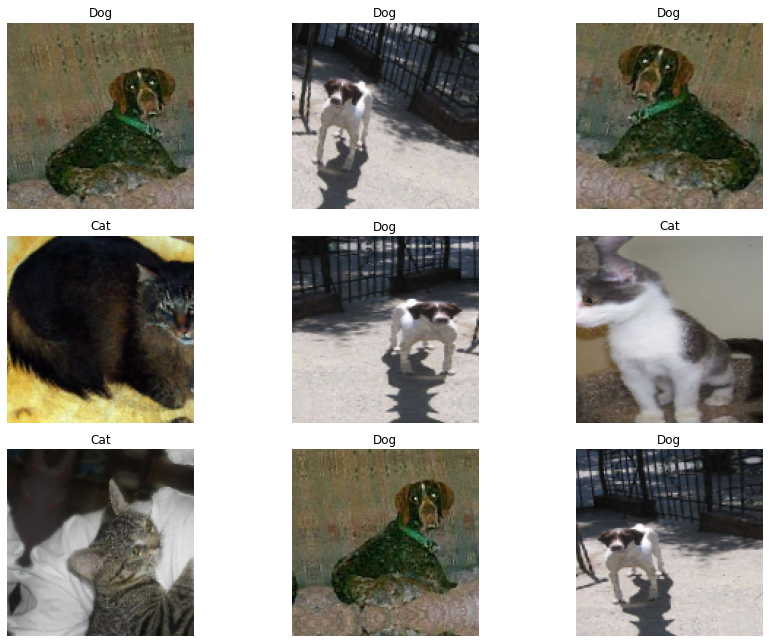

In [ ]:
sample_train = train_df.sample(10) # 10 random sample from training set
sample_train_gen = train_datagen.flow_from_dataframe(
    sample_train,
    directory=TRAIN_DIR,
    x_col="file",
    y_col="type",
    target_size=(IMG_SIZE, IMG_SIZE),
    classes=["cat", "dog"],
    class_mode="binary",
    batch_size=BATCH_SIZE
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    ax = plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in sample_train_gen:
        image = X_batch[i]
        plt.imshow(image)
        ax.axis("off")
        label: str
        if Y_batch[i] == 0: label = "Cat"
        else: label = "Dog"
        ax.set_title(label)
        break
plt.tight_layout()
plt.show()

Found 9 validated image filenames.


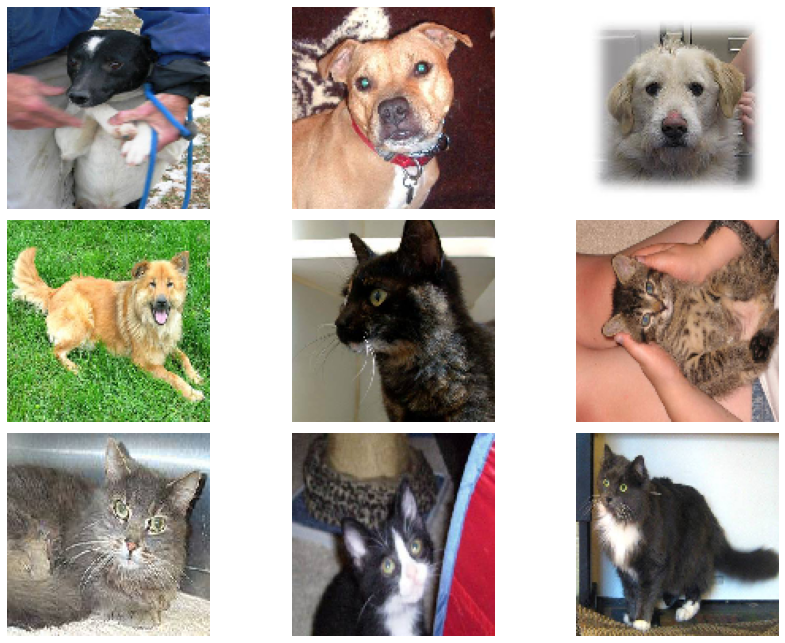

In [ ]:
sample_test = test_df.iloc[0:9, :] # 10 first sample from testing set
sample_test_gen = test_datagen.flow_from_dataframe(
    sample_test,
    directory=TEST_DIR,
    x_col="file",
    y_col=None,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=False
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    ax = plt.subplot(4, 3, i+1)
    for X_batch in sample_test_gen:
        image = X_batch[0]
        plt.imshow(image)
        ax.axis("off")
        break
plt.tight_layout()
plt.show()

# Build the model  
The model architecture is based on VGG model, with 4 blocks of convolutional layers, each block comprises of a conv2D layer and a max pooling layer. All convolutional layers have kernel size of 3x3 and pooling layers have kernel size 2x2. The size of convolution layers in the 4 blocks are 32, 64, 128, 256 to filter more complex characteristics as the input goes through the network. The 5th block in the network which is the output block will have an average pooling layer to filter the most noticible features in the picture, and 3 dense layers (fully-connected layer), one dense layer with size of 512 and one layer with 128 to gradually select the extracted features from the picture and the final dense layer is for calculating sigmoid probability. All layers will use Relu as activation function, except for the final dense layer which will use Sigmoid.  
_Reference: https://arxiv.org/pdf/1409.1556.pdf_

In [ ]:
model = Sequential()
# Block 1
model.add(Conv2D(32, (3,3), padding="same", activation="relu", kernel_initializer="he_uniform", input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
model.add(MaxPooling2D((2,2)))
# Block 2
model.add(Conv2D(64, (3,3), padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling2D((2,2)))
# Block 3
model.add(Conv2D(128, (3,3), padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling2D((2,2)))
# Block 4
model.add(Conv2D(256, (3,3), padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling2D((2,2)))
# Output block
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
model.add(Dense(1, activation="sigmoid"))

# Summary the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [ ]:
# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
# A callback function to automatically modify learning rate while training
LR_Reduction =  ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.35,
                                            min_lr = 0.00001,
                                            verbose = 1)
callback_func = [LR_Reduction]

# Training Phase

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=75,  # 18750 images = batch_size * steps
      epochs=EPOCH,
      validation_data=validation_generator,
      validation_steps=25,  # 6250 images = batch_size * steps
      verbose=2,
      callbacks=callback_func)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
75/75 - 958s - loss: 0.7181 - accuracy: 0.5446 - val_loss: 0.6672 - val_accuracy: 0.5834
Epoch 2/20
75/75 - 948s - loss: 0.6401 - accuracy: 0.6188 - val_loss: 0.6180 - val_accuracy: 0.6531
Epoch 3/20
75/75 - 947s - loss: 0.6160 - accuracy: 0.6562 - val_loss: 0.6025 - val_accuracy: 0.6723
Epoch 4/20
75/75 - 944s - loss: 0.5855 - accuracy: 0.6856 - val_loss: 0.5659 - val_accuracy: 0.7085
Epoch 5/20
75/75 - 942s - loss: 0.5465 - accuracy: 0.7178 - val_loss: 0.5417 - val_accuracy: 0.7235
Epoch 6/20
75/75 - 943s - loss: 0.5547 - accuracy: 0.7084 - val_loss: 0.5383 - val_accuracy: 0.7283
Epoch 7/20
75/75 - 945s - loss: 0.5150 - accuracy: 0.7419 - val_loss: 0.5010 - val_accuracy: 0.7493
Epoch 8/20
75/75 - 941s - loss: 0.5035 - accuracy: 0.7513 - val_loss: 0.4782 - val_accuracy: 0.7754
Epoch 9/20
75/75 - 940s - loss: 0.4768 - accuracy: 0.7715 - val_loss: 0.4858 - val_accuracy: 0.7598
Epoch 10/20
75/75 - 983s - loss: 0.4593 - accuracy: 0.7815 - val_loss: 0.4355 - val_accuracy: 0.8016

# Accuracy and Loss Visualization

In [ ]:
# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, color='blue', label='train')
plt.plot(epochs, val_acc, color='orange', label='validation')
plt.title('Training and Validation accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, color='blue', label='train')
plt.plot(epochs, val_loss, color='orange', label='validation')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.figure()

plt.close()

# Evaluate final Accuracy of the model

In [ ]:
_, acc = model.evaluate_generator(
    validation_generator, 
    steps=25, # 6250 images = batch_size * steps
    verbose=2)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 - 88s - loss: 0.2620 - accuracy: 0.8899
> 88.992


# Save the model

In [ ]:
# Model file
model.save('model.h5', overwrite=True)

# Model weights
model.save_weights('weights.h5', overwrite=True)

# Load the model

In [ ]:
# Load the model
model = load_model("model.h5")

# Test with the first 9 testing images

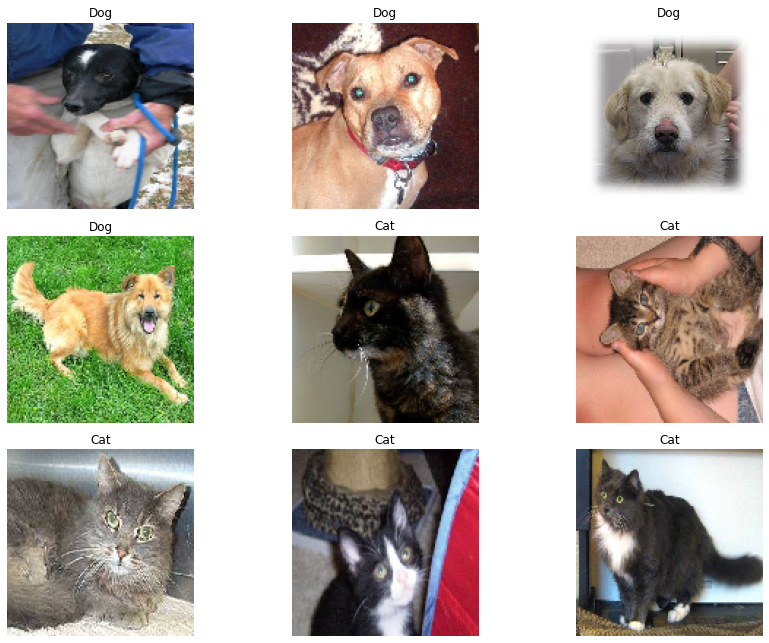

In [ ]:
sample_test_gen.reset()
results = model.predict(sample_test_gen)
sample_test_gen.reset()
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(4, 3, i+1)
    for X_batch in sample_test_gen:
        image = X_batch[0]
        plt.imshow(image)
        label: str
        if results[i] < 0.5: label = "Cat"
        else: label = "Dog"
        ax.set_title(label)
        ax.axis("off")
        break
plt.tight_layout()
plt.show()

# IMAGE CLASSIFIER

Model path: ./model.h5
Image directory: ./
Image file name: dog1.jpg
Found 1 validated image filenames.


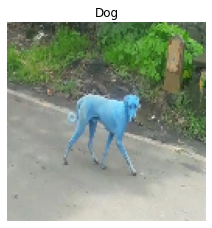

In [ ]:
# CONSTANTS FOR USING THE MODEL
IMG_SIZE = 128
# Get user input
model_path = input("Model path: ")
image_dir= input("Image directory: ")
try:
  isFile = os.path.isfile(model_path)
  isDir = os.path.isdir(image_dir)
  if isFile == False or isDir == False: raise FileNotFoundError
except FileNotFoundError:
  print('Error: Input file/directory is not exist')
else:
  image_name= input("Image file name: ")
  if os.path.exists(os.path.join(image_dir, image_name)):
    # Create dataframe from input path
    img = os.listdir(image_dir)
    img_df = pd.DataFrame({
        "file": img
    })
    # Load the model
    model = load_model(model_path)
    # Data generator for transforming input image
    test_datagen = ImageDataGenerator(
        rescale = 1./255
    )
    image_test=img_df.loc[img_df["file"]==image_name]
    image_gen = test_datagen.flow_from_dataframe(
        image_test,
        directory=image_dir,
        x_col="file",
        y_col=None,
        class_mode=None,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size = 1
    )
    # Predict the image
    results = model.predict(image_gen)
    # Print output
    plt.figure(figsize=(12, 12))
    for i in range(1):
        ax = plt.subplot(4, 3, i+1)
        for X_batch in image_gen:
            image = X_batch[0]
            plt.imshow(image)
            label: str
            if results[i] < 0.5: label = "Cat"
            else: label = "Dog"
            ax.set_title(label)
            ax.axis("off")
            break
    plt.tight_layout()
    plt.show()
  else:
    print("Invalid image path.")